# Workflow for a multi-regional energy system

In this application of the FINE framework, a multi-regional energy system is modeled and optimized.

All classes which are available to the user are utilized and examples of the selection of different parameters within these classes are given.

The workflow is structures as follows:
1. Required packages are imported and the input data path is set
2. An energy system model instance is created
3. Commodity sources are added to the energy system model
4. Commodity conversion components are added to the energy system model
5. Commodity storages are added to the energy system model
6. Commodity transmission components are added to the energy system model
7. Commodity sinks are added to the energy system model
8. The energy system model is optimized
9. Selected optimization results are presented


# 1. Import required packages and set input data path

The FINE framework is imported which provides the required classes and functions for modeling the energy system.

In [1]:
import FINE as fn
from getData import getData
import os
cwd = os.getcwd()
data = getData()

%matplotlib inline  
%load_ext autoreload
%autoreload 2

# 2. Create an energy system model instance 

The structure of the energy system model is given by the considered locations, commodities, the number of time steps as well as the hours per time step.

The commodities are specified by a unit (i.e. 'GW_electric', 'GW_H2lowerHeatingValue', 'Mio. t CO2/h') which can be given as an energy or mass unit per hour. Furthermore, the cost unit and length unit are specified.

In [2]:
locations = {'cluster_0', 'cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5', 'cluster_6', 'cluster_7'}
commodityUnitDict = {'electricity': r'GW$_{el}$', 'methane': r'GW$_{CH_{4},LHV}$', 'biogas': r'GW$_{biogas,LHV}$',
                     'CO2': r'Mio. t$_{CO_2}$/h', 'hydrogen': r'GW$_{H_{2},LHV}$'}
commodities = {'electricity', 'hydrogen', 'methane', 'biogas', 'CO2'}
numberOfTimeSteps=8760
hoursPerTimeStep=1

In [3]:
esM = fn.EnergySystemModel(locations=locations, commodities=commodities, numberOfTimeSteps=8760,
                           commodityUnitsDict=commodityUnitDict,
                           hoursPerTimeStep=1, costUnit='1e9 Euro', lengthUnit='km', verboseLogLevel=0)

In [4]:
CO2_reductionTarget = 1

# 3. Add commodity sources to the energy system model

## 3.1. Electricity sources

### Wind onshore

In [5]:
esM.add(fn.Source(esM=esM, name='Wind (onshore)', commodity='electricity', hasCapacityVariable=True,
                  operationRateMax=data['Wind (onshore), operationRateMax'],
                  capacityMax=data['Wind (onshore), capacityMax'],
                  investPerCapacity=1.1, opexPerCapacity=1.1*0.02, interestRate=0.08,
                  economicLifetime=20))

Full load hours:

In [6]:
data['Wind (onshore), operationRateMax'].sum()

cluster_0    2300.406907
cluster_1    1082.032187
cluster_2    1447.812026
cluster_3    1448.827987
cluster_4    1935.618218
cluster_5    1757.696047
cluster_6    1286.944636
cluster_7    1199.380071
dtype: float64

### Wind offshore

In [7]:
esM.add(fn.Source(esM=esM, name='Wind (offshore)', commodity='electricity', hasCapacityVariable=True,
                  operationRateMax=data['Wind (offshore), operationRateMax'],
                  capacityMax=data['Wind (offshore), capacityMax'],
                  investPerCapacity=2.3, opexPerCapacity=2.3*0.02, interestRate=0.08,
                  economicLifetime=20))

Full load hours:

In [8]:
data['Wind (offshore), operationRateMax'].sum()

cluster_0    4332.977326
cluster_1       0.000000
cluster_2       0.000000
cluster_3       0.000000
cluster_4    3963.044612
cluster_5    3459.283279
cluster_6       0.000000
cluster_7       0.000000
dtype: float64

### PV

In [9]:
esM.add(fn.Source(esM=esM, name='PV', commodity='electricity', hasCapacityVariable=True,
                  operationRateMax=data['PV, operationRateMax'], capacityMax=data['PV, capacityMax'],
                  investPerCapacity=0.65, opexPerCapacity=0.65*0.02, interestRate=0.08,
                  economicLifetime=25))

Full load hours:

In [10]:
data['PV, operationRateMax'].sum()

cluster_0    859.175855
cluster_1    970.535848
cluster_2    913.049274
cluster_3    917.880212
cluster_4    875.448945
cluster_5    904.590003
cluster_6    984.223517
cluster_7    992.311727
dtype: float64

### Exisisting run-of-river hydroelectricity plants

In [11]:
esM.add(fn.Source(esM=esM, name='Existing run-of-river plants', commodity='electricity',
                  hasCapacityVariable=True,
                  operationRateFix=data['Existing run-of-river plants, operationRateFix'], tsaWeight=0.01,
                  capacityFix=data['Existing run-of-river plants, capacityFix'],
                  investPerCapacity=0, opexPerCapacity=0.208))

## 3.2. Methane (natural gas and biogas)

### Natural gas

In [12]:
esM.add(fn.Source(esM=esM, name='Natural gas purchase', commodity='methane',
                  hasCapacityVariable=False, commodityCost=0.0331*1e-3))

### Biogas

In [13]:
esM.add(fn.Source(esM=esM, name='Biogas purchase', commodity='biogas',
                  operationRateMax=data['Biogas, operationRateMax'], hasCapacityVariable=False,
                  commodityCost=0.05409*1e-3))

## 3.3 CO2

### CO2

The CO2 source is required for the case in which it can be mixed with conventional natural gas.

In [14]:
esM.add(fn.Source(esM=esM, name='CO2 from enviroment', commodity='CO2',
                  hasCapacityVariable=False, commodityLimitID='CO2 limit', yearlyLimit=366*(1-CO2_reductionTarget)))

# 4. Add conversion components to the energy system model

### Combined cycle gas turbine plants

In [15]:
esM.add(fn.Conversion(esM=esM, name='CCGT plants (methane)', physicalUnit=r'GW$_{el}$',
                      commodityConversionFactors={'electricity':1, 'methane':-1/0.625, 'CO2':201*1e-6/0.625},
                      hasCapacityVariable=True,
                      investPerCapacity=0.65, opexPerCapacity=0.021, interestRate=0.08,
                      economicLifetime=33))

### New combined cycle gas turbine plants for biogas

In [16]:
esM.add(fn.Conversion(esM=esM, name='New CCGT plants (biogas)', physicalUnit=r'GW$_{el}$',
                      commodityConversionFactors={'electricity':1, 'biogas':-1/0.635},
                      hasCapacityVariable=True, 
                      investPerCapacity=0.7, opexPerCapacity=0.021, interestRate=0.08,
                      economicLifetime=33))

### New combined cycly gas turbines for hydrogen

In [17]:
esM.add(fn.Conversion(esM=esM, name='New CCGT plants (hydrogen)', physicalUnit=r'GW$_{el}$',
                      commodityConversionFactors={'electricity':1, 'hydrogen':-1/0.6},
                      hasCapacityVariable=True, 
                      investPerCapacity=0.7, opexPerCapacity=0.021, interestRate=0.08,
                      economicLifetime=33))

### Electrolyzers

In [18]:
esM.add(fn.Conversion(esM=esM, name='Electroylzers', physicalUnit=r'GW$_{el}$',
                      commodityConversionFactors={'electricity':-1, 'hydrogen':0.7},
                      hasCapacityVariable=True, 
                      investPerCapacity=0.5, opexPerCapacity=0.5*0.025, interestRate=0.08,
                      economicLifetime=10))

### rSOC

In [19]:
capexRSOC=1.5

esM.add(fn.Conversion(esM=esM, name='rSOEC', physicalUnit=r'GW$_{el}$', linkedConversionCapacityID='rSOC',
                      commodityConversionFactors={'electricity':-1, 'hydrogen':0.6},
                      hasCapacityVariable=True, 
                      investPerCapacity=capexRSOC/2, opexPerCapacity=capexRSOC*0.02/2, interestRate=0.08,
                      economicLifetime=10))

esM.add(fn.Conversion(esM=esM, name='rSOFC', physicalUnit=r'GW$_{el}$', linkedConversionCapacityID='rSOC',
                      commodityConversionFactors={'electricity':1, 'hydrogen':-1/0.6},
                      hasCapacityVariable=True, 
                      investPerCapacity=capexRSOC/2, opexPerCapacity=capexRSOC*0.02/2, interestRate=0.08,
                      economicLifetime=10))

# 5. Add commodity storages to the energy system model

## 5.1. Electricity storage

### Lithium ion batteries

The self discharge of a lithium ion battery is here described as 3% per month. The self discharge per hours is obtained using the equation (1-$\text{selfDischarge}_\text{hour})^{30*24\text{h}} = 1-\text{selfDischarge}_\text{month}$.

In [20]:
esM.add(fn.Storage(esM=esM, name='Li-ion batteries', commodity='electricity',
                   hasCapacityVariable=True, chargeEfficiency=0.95,
                   cyclicLifetime=10000, dischargeEfficiency=0.95, selfDischarge=1-(1-0.03)**(1/(30*24)),
                   chargeRate=1, dischargeRate=1, doPreciseTsaModeling=False,
                   investPerCapacity=0.151, opexPerCapacity=0.002, interestRate=0.08,
                   economicLifetime=22))

## 5.2. Hydrogen storage

### Hydrogen filled salt caverns
The maximum capacity is here obtained by: dividing the given capacity (which is given for methane) by the lower heating value of methane and then multiplying it with the lower heating value of hydrogen.

In [21]:
esM.add(fn.Storage(esM=esM, name='Salt caverns (hydrogen)', commodity='hydrogen',
                   hasCapacityVariable=True, capacityVariableDomain='continuous',
                   capacityPerPlantUnit=133,
                   chargeRate=1/470.37, dischargeRate=1/470.37, sharedPotentialID='Existing salt caverns',
                   stateOfChargeMin=0.33, stateOfChargeMax=1, capacityMax=data['Salt caverns (hydrogen), capacityMax'],
                   investPerCapacity=0.00011, opexPerCapacity=0.00057, interestRate=0.08,
                   economicLifetime=30))

## 5.3. Methane storage

### Methane filled salt caverns

In [22]:
esM.add(fn.Storage(esM=esM, name='Salt caverns (biogas)', commodity='biogas',
                   hasCapacityVariable=True, capacityVariableDomain='continuous',
                   capacityPerPlantUnit=443,
                   chargeRate=1/470.37, dischargeRate=1/470.37, sharedPotentialID='Existing salt caverns',
                   stateOfChargeMin=0.33, stateOfChargeMax=1, capacityMax=data['Salt caverns (methane), capacityMax'],
                   investPerCapacity=0.00004, opexPerCapacity=0.00001, interestRate=0.08,
                   economicLifetime=30))

## 5.4 Pumped hydro storage

### Pumped hydro storage

In [23]:
esM.add(fn.Storage(esM=esM, name='Pumped hydro storage', commodity='electricity',
                   chargeEfficiency=0.88, dischargeEfficiency=0.88,
                   hasCapacityVariable=True, selfDischarge=1-(1-0.00375)**(1/(30*24)),
                   chargeRate=0.16, dischargeRate=0.12, capacityFix=data['Pumped hydro storage, capacityFix'],
                   investPerCapacity=0, opexPerCapacity=0.000153))

# 6. Add commodity transmission components to the energy system model

## 6.1. Electricity transmission

### AC cables

esM.add(fn.LinearOptimalPowerFlow(esM=esM, name='AC cables', commodity='electricity',
                                  hasCapacityVariable=True, capacityFix=data['AC cables, capacityFix'],
                                  reactances=data['AC cables, reactances']))

In [24]:
esM.add(fn.Transmission(esM=esM, name='AC cables', commodity='electricity',
                                  hasCapacityVariable=True, capacityFix=data['AC cables, capacityFix']))

The distances of a component are set to a normalized value of 1.


### DC cables

In [25]:
esM.add(fn.Transmission(esM=esM, name='DC cables', commodity='electricity', losses=data['DC cables, losses'],
                        distances=data['DC cables, distances'],
                        hasCapacityVariable=True, capacityFix=data['DC cables, capacityFix']))

## 6.2 Methane transmission

### Methane pipeline

In [26]:
esM.add(fn.Transmission(esM=esM, name='Pipelines (biogas)', commodity='biogas', 
                        distances=data['Pipelines, distances'],
                        hasCapacityVariable=True, hasIsBuiltBinaryVariable=True, bigM=300,
                        locationalEligibility=data['Pipelines, eligibility'],
                        capacityMax=data['Pipelines, eligibility']*15, sharedPotentialID='pipelines',
                        investPerCapacity=0.000037, investIfBuilt=0.000314,
                        interestRate=0.08, economicLifetime=40))

esM.getComponent('Pipelines (methane)')._mapC['cluster_0_cluster_4'][1]

## 6.3 Hydrogen transmission

### Hydrogen pipelines

In [27]:
esM.add(fn.Transmission(esM=esM, name='Pipelines (hydrogen)', commodity='hydrogen',
                        distances=data['Pipelines, distances'],
                        hasCapacityVariable=True, hasIsBuiltBinaryVariable=True, bigM=300,
                        locationalEligibility=data['Pipelines, eligibility'],
                        capacityMax=data['Pipelines, eligibility']*15, sharedPotentialID='pipelines',
                        investPerCapacity=0.000177, investIfBuilt=0.00033,
                        interestRate=0.08, economicLifetime=40))

esM.getComponent('Pipeline (hydrogen)')._mapC

# 7. Add commodity sinks to the energy system model

## 7.1. Electricity sinks

### Electricity demand

In [28]:
esM.add(fn.Sink(esM=esM, name='Electricity demand', commodity='electricity',
                hasCapacityVariable=False, operationRateFix=data['Electricity demand, operationRateFix']))

## 7.2. Hydrogen sinks

### Fuel cell electric vehicle (FCEV) demand

In [29]:
FCEV_penetration=0.5
esM.add(fn.Sink(esM=esM, name='Hydrogen demand', commodity='hydrogen', hasCapacityVariable=False,
                operationRateFix=data['Hydrogen demand, operationRateFix']*FCEV_penetration))

## 7.3. CO2 sinks

### CO2 exiting the system's boundary

In [30]:
esM.add(fn.Sink(esM=esM, name='CO2 to enviroment', commodity='CO2',
                hasCapacityVariable=False, commodityLimitID='CO2 limit', yearlyLimit=366*(1-CO2_reductionTarget)))

# 8. Optimize energy system model

All components are now added to the model and the model can be optimized. If the computational complexity of the optimization should be reduced, the time series data of the specified components can be clustered before the optimization and the parameter timeSeriesAggregation is set to True in the optimize call.

In [31]:
esM.cluster(numberOfTypicalPeriods=7)


Clustering time series data with 7 typical periods and 24 time steps per period...
		(3.8584 sec)



In [32]:
esM.optimize(timeSeriesAggregation=True, optimizationSpecs='OptimalityTol=1e-3 method=2 cuts=0')

Time series aggregation specifications:
Number of typical periods:7, number of time steps per periods:24

Declaring sets, variables and constraints for SourceSinkModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(0.4530 sec)

Declaring sets, variables and constraints for ConversionModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(0.1875 sec)

Declaring sets, variables and constraints for StorageModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(1.6246 sec)

Declaring sets, variables and constraints for TransmissionModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(0.2968 sec)

Declaring shared potential constraint...
		(0.0000 sec)

Declaring commodity balances...
		(0.5936 sec)

Declaring objective function...
		(0.2656 sec)

Academic license - for non-commercial use only
Read LP format model from file C:\Users\T58C8~1.GRO\AppData\Local\Temp\tmpq6_vbzbj.pyomo.lp
Rea

for SourceSinkModel ...    (0.7342sec)
for ConversionModel ...    (0.6248sec)
for StorageModel ...       (1.8277sec)
for TransmissionModel ...  (1.6090sec)
		(4.7957 sec)



# 9. Selected results output

Plot locations (GeoPandas required)

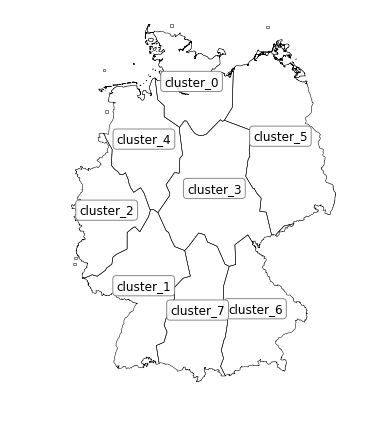

In [33]:
locFilePath = os.path.join(cwd, 'InputData', 'SpatialData','ShapeFiles', 'clusteredRegions.shp')
fig, ax = fn.plotLocations(locFilePath, plotLocNames=True, indexColumn='index')

### Sources and Sink

Show optimization summary

In [34]:
esM.getOptimizationSummary("SourceSinkModel", outputLevel=2)

cluster_0  \
Component                    Property    Unit                                
Biogas purchase              TAC         [1e9 Euro/a]             0.450598   
                             commodCosts [1e9 Euro/a]             0.450598   
                             operation   [GW$_{biogas,LHV}$*h/a]   8330.51   
Electricity demand           operation   [GW$_{el}$*h/a]           30957.9   
Existing run-of-river plants TAC         [1e9 Euro/a]                    0   
                             capacity    [GW$_{el}$]                   NaN   
                             operation   [GW$_{el}$*h/a]               NaN   
                             opexCap     [1e9 Euro/a]                  NaN   
Hydrogen demand              operation   [GW$_{H_{2},LHV}$*h/a]    4765.07   
PV                           TAC         [1e9 Euro/a]              1.32784   
                             capacity    [GW$_{el}$]               17.9701   
                             capexCap    [1e9 Euro/a]              1.09422   
                             invest      [1e9 Euro]                11.6806   
                             operation   [GW$_{el}$*h/a]           11033.8   
                             opexCap     [1e9 Euro/a]             0.233612   
Wind (offshore)              TAC         [1e9 Euro/a]              4.51415   
                             capacity    [GW$_{el}$]                16.107   
                             capexCap    [1e9 Euro/a]              3.77323   
                             invest      [1e9 Euro]                37.0461   
                             operation   [GW$_{el}$*h/a]           51809.9   
                             opexCap     [1e9 Euro/a]             0.740923   
Wind (onshore)               TAC         [1e9 Euro/a]              7.79686   
                             capacity    [GW$_{el}$]               58.1693   
                             capexCap    [1e9 Euro/a]              6.51714   
                             invest      [1e9 Euro]                63.9862   
                             operation   [GW$_{el}$*h/a]            107584   
                             opexCap     [1e9 Euro/a]              1.27972   

                                                                 cluster_1  \
Component                    Property    Unit                                
Biogas purchase              TAC         [1e9 Euro/a]             0.407035   
                             commodCosts [1e9 Euro/a]             0.407035   
                             operation   [GW$_{biogas,LHV}$*h/a]   7525.14   
Electricity demand           operation   [GW$_{el}$*h/a]            111621   
Existing run-of-river plants TAC         [1e9 Euro/a]             0.113235   
                             capacity    [GW$_{el}$]              0.544397   
                             operation   [GW$_{el}$*h/a]           2668.85   
                             opexCap     [1e9 Euro/a]             0.113235   
Hydrogen demand              operation   [GW$_{H_{2},LHV}$*h/a]    13481.3   
PV                           TAC         [1e9 Euro/a]              1.90692   
                             capacity    [GW$_{el}$]               25.8072   
                             capexCap    [1e9 Euro/a]              1.57143   
                             invest      [1e9 Euro]                16.7747   
                             operation   [GW$_{el}$*h/a]           23732.8   
                             opexCap     [1e9 Euro/a]             0.335494   
Wind (offshore)              TAC         [1e9 Euro/a]                    0   
                             capacity    [GW$_{el}$]                   NaN   
                             capexCap    [1e9 Euro/a]                  NaN   
                             invest      [1e9 Euro]                    NaN   
                             operation   [GW$_{el}$*h/a]               NaN   
                             opexCap     [1e9 Euro/a]                  NaN   
Wind (on

Plot installed capacities

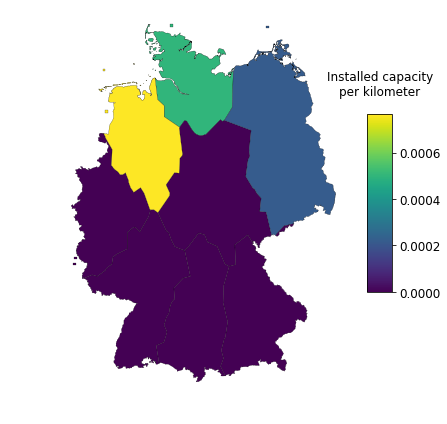

In [35]:
fig, ax = fn.plotLocationalColorMap(esM, 'Wind (offshore)', locFilePath, 'index', perArea=True)

Plot operation time series (either one or two dimensional)

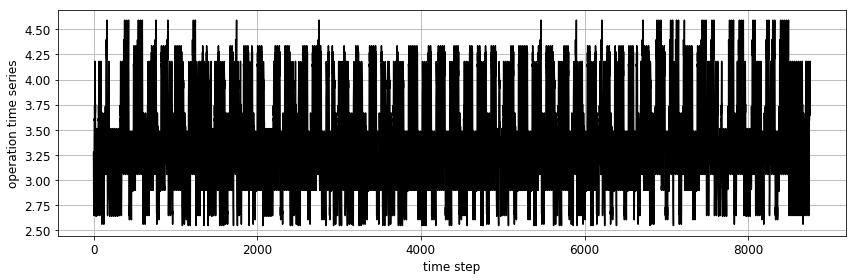

In [36]:
fig, ax = fn.plotOperation(esM, 'Electricity demand', 'cluster_0')

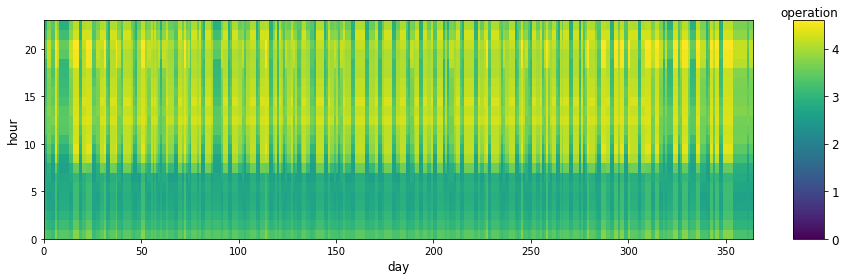

In [37]:
fig, ax = fn.plotOperationColorMap(esM, 'Electricity demand', 'cluster_0')

### Conversion

Show optimization summary

In [38]:
esM.getOptimizationSummary("ConversionModel", outputLevel=2)

cluster_0   cluster_1  \
Component                  Property  Unit                                    
Electroylzers              TAC       [1e9 Euro/a]      2.15756           0   
                           capacity  [GW$_{el}$]       24.7954           0   
                           capexCap  [1e9 Euro/a]      1.84762           0   
                           invest    [1e9 Euro]        12.3977           0   
                           operation [GW$_{el}$*h/a]   83158.7           0   
                           opexCap   [1e9 Euro/a]     0.309942           0   
New CCGT plants (biogas)   TAC       [1e9 Euro/a]            0   0.0911827   
                           capacity  [GW$_{el}$]             0     1.11476   
                           capexCap  [1e9 Euro/a]            0   0.0677729   
                           invest    [1e9 Euro]              0    0.780329   
                           operation [GW$_{el}$*h/a]         0     2465.84   
                           opexCap   [1e9 Euro/a]            0   0.0234099   
New CCGT plants (hydrogen) TAC       [1e9 Euro/a]            0  0.00890409   
                           capacity  [GW$_{el}$]             0    0.108857   
                           capexCap  [1e9 Euro/a]            0  0.00661809   
                           invest    [1e9 Euro]              0      0.0762   
                           operation [GW$_{el}$*h/a]         0     393.309   
                           opexCap   [1e9 Euro/a]            0    0.002286   

                                                     cluster_2  cluster_3  \
Component                  Property  Unit                                   
Electroylzers              TAC       [1e9 Euro/a]            0          0   
                           capacity  [GW$_{el}$]             0          0   
                           capexCap  [1e9 Euro/a]            0          0   
                           invest    [1e9 Euro]              0          0   
                           operation [GW$_{el}$*h/a]         0          0   
                           opexCap   [1e9 Euro/a]            0          0   
New CCGT plants (biogas)   TAC       [1e9 Euro/a]     0.449689   0.333637   
                           capacity  [GW$_{el}$]       5.49768    4.07889   
                           capexCap  [1e9 Euro/a]     0.334238   0.247981   
                           invest    [1e9 Euro]        3.84837    2.85522   
                           operation [GW$_{el}$*h/a]   13026.6    10522.8   
                           opexCap   [1e9 Euro/a]     0.115451  0.0856567   
New CCGT plants (hydrogen) TAC       [1e9 Euro/a]     0.487943          0   
                           capacity  [GW$_{el}$]       5.96536          0   
                           capexCap  [1e9 Euro/a]     0.362671          0   
                           invest    [1e9 Euro]        4.17575          0   
                           operation [GW$_{el}$*h/a]   24505.1          0   
                           opexCap   [1e9 Euro/a]     0.125272          0   

                                                      cluster_4  cluster_5  \
Component                  Property  Unit                                    
Electroylzers              TAC       [1e9 Euro/a]      0.673243    1.68521   
                           capacity  [GW$_{el}$]        7.73711     19.367   
                           capexCap  [1e9 Euro/a]      0.576529    1.44313   
                           invest    [1e9 Euro]         3.86856     9.6835   
                           operation [GW$_{el}$*h/a]    18561.1    52808.1   
                           opexCap   [1e9 Euro/a]     0.0967139   0.242088   
New CCGT plants (biogas)   TAC       [1e9 Euro/a]      0.370251    0.12377   
                           capacity  [GW$_{el}$]        4.52651    1.51316   
                           capexCap  [1e9 Euro/a]      0.275194  0.0919941   
                           invest    [1e9 Euro]         3.16856    1.05921   
               

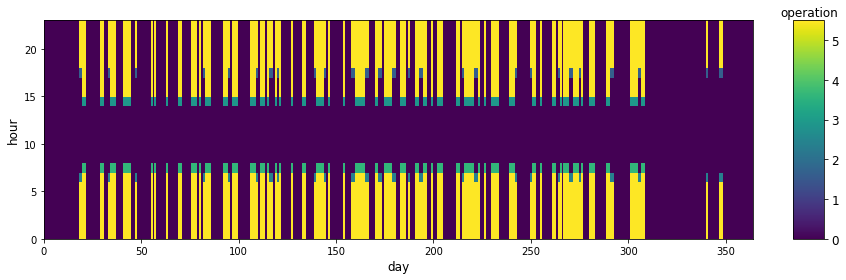

In [39]:
fig, ax = fn.plotOperationColorMap(esM, 'New CCGT plants (biogas)', 'cluster_2')

### Storage

Show optimization summary

In [40]:
esM.getOptimizationSummary("StorageModel", outputLevel=2)

cluster_0  \
Component               Property           Unit                                  
Li-ion batteries        TAC                [1e9 Euro/a]              0.0442068   
                        capacity           [GW$_{el}$*h]               2.63091   
                        capexCap           [1e9 Euro/a]               0.038945   
                        invest             [1e9 Euro]                 0.397268   
                        operationCharge    [GW$_{el}$*h/a]             987.065   
                        operationDischarge [GW$_{el}$*h/a]             890.187   
                        opexCap            [1e9 Euro/a]             0.00526182   
Pumped hydro storage    TAC                [1e9 Euro/a]                      0   
                        capacity           [GW$_{el}$*h]                   NaN   
                        operationCharge    [GW$_{el}$*h/a]                 NaN   
                        operationDischarge [GW$_{el}$*h/a]                 NaN   
                        opexCap            [1e9 Euro/a]                    NaN   
Salt caverns (biogas)   TAC                [1e9 Euro/a]                      0   
                        capacity           [GW$_{biogas,LHV}$*h]             0   
                        capexCap           [1e9 Euro/a]                      0   
                        invest             [1e9 Euro]                        0   
                        operationCharge    [GW$_{biogas,LHV}$*h/a]           0   
                        operationDischarge [GW$_{biogas,LHV}$*h/a]           0   
                        opexCap            [1e9 Euro/a]                      0   
Salt caverns (hydrogen) TAC                [1e9 Euro/a]               0.716143   
                        capacity           [GW$_{H_{2},LHV}$*h]        1235.22   
                        capexCap           [1e9 Euro/a]              0.0120693   
                        invest             [1e9 Euro]                 0.135874   
                        operationCharge    [GW$_{H_{2},LHV}$*h/a]      14342.7   
                        operationDischarge [GW$_{H_{2},LHV}$*h/a]      14342.7   
                        opexCap            [1e9 Euro/a]               0.704073   

                                                                     cluster_1  \
Component               Property           Unit                                  
Li-ion batteries        TAC                [1e9 Euro/a]               0.386617   
                        capacity           [GW$_{el}$*h]                23.009   
                        capexCap           [1e9 Euro/a]               0.340599   
                        invest             [1e9 Euro]                  3.47436   
                        operationCharge    [GW$_{el}$*h/a]             6524.33   
                        operationDischarge [GW$_{el}$*h/a]             5884.83   
                        opexCap            [1e9 Euro/a]               0.046018   
Pumped hydro storage    TAC                [1e9 Euro/a]             0.00137868   
                        capacity           [GW$_{el}$*h]                 9.011   
                        operationCharge    [GW$_{el}$*h/a]             3196.27   
                        operationDischarge [GW$_{el}$*h/a]             2475.12   
                        opexCap            [1e9 Euro/a]             0.00137868   
Salt caverns (biogas)   TAC                [1e9 Euro/a]                      0   
                        capacity           [GW$_{biogas,LHV}$*h]           NaN   
                        capexCap           [1e9 Euro/a]                    NaN   
                        invest             [1e9 Euro]                      NaN   
                        operationCharge    [GW$_{biogas,LHV}$*h/a]         NaN   
                        operationDischarge [GW$_{biogas,LHV}$*h/a]         NaN   
                        opexCap            [1e9 Euro/a]                    NaN   
Salt caverns (hydrogen) TAC                [1e9 Eu

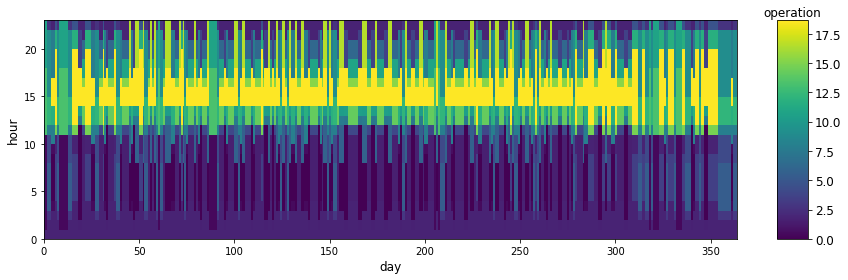

In [41]:
fig, ax = fn.plotOperationColorMap(esM, 'Li-ion batteries', 'cluster_2', 
                                   variableName='stateOfChargeOperationVariablesOptimum')

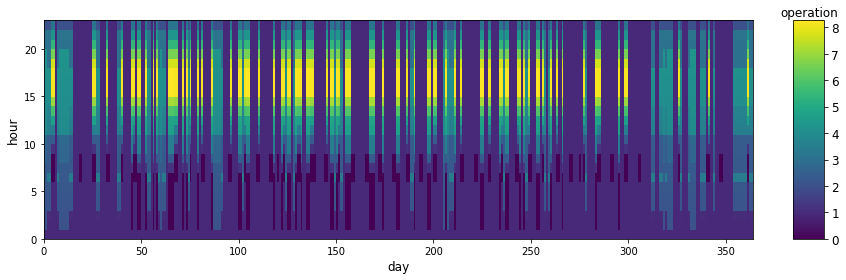

In [42]:
fig, ax = fn.plotOperationColorMap(esM, 'Pumped hydro storage', 'cluster_2',
                                  variableName='stateOfChargeOperationVariablesOptimum')

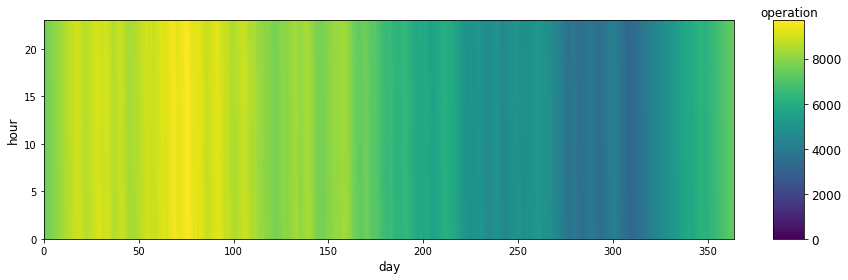

In [43]:
fig, ax = fn.plotOperationColorMap(esM, 'Salt caverns (biogas)', 'cluster_2',
                                  variableName='stateOfChargeOperationVariablesOptimum')

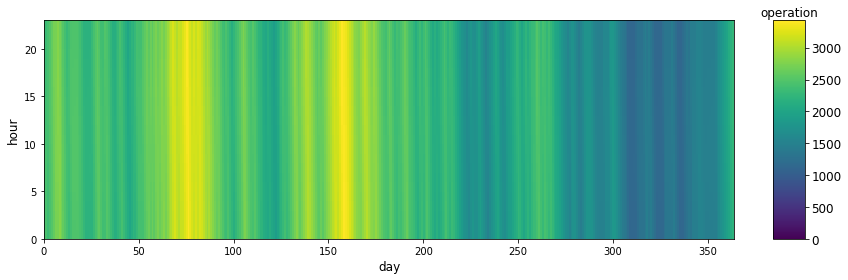

In [44]:
fig, ax = fn.plotOperationColorMap(esM, 'Salt caverns (hydrogen)', 'cluster_2',
                                  variableName='stateOfChargeOperationVariablesOptimum')

## Transmission

Show optimization summary

In [45]:
esM.getOptimizationSummary("TransmissionModel", outputLevel=2).loc['Pipelines (hydrogen)']

cluster_0    cluster_1  \
Property     Unit                   LocationIn                             
TAC          [1e9 Euro/a]           cluster_0             0            0   
                                    cluster_1             0            0   
                                    cluster_2             0  6.45417e-05   
                                    cluster_3             0            0   
                                    cluster_4   0.000117844            0   
                                    cluster_5             0            0   
                                    cluster_6             0            0   
                                    cluster_7             0  3.84993e-05   
capacity     [GW$_{H_{2},LHV}$]     cluster_0           NaN          NaN   
                                    cluster_1           NaN          NaN   
                                    cluster_2           NaN      6.83203   
                                    cluster_3           NaN          NaN   
                                    cluster_4       14.0141          NaN   
                                    cluster_5           NaN          NaN   
                                    cluster_6           NaN          NaN   
                                    cluster_7           NaN      3.32304   
capexCap     [1e9 Euro/a]           cluster_0           NaN          NaN   
                                    cluster_1           NaN          NaN   
                                    cluster_2           NaN  5.07048e-05   
                                    cluster_3           NaN          NaN   
                                    cluster_4   0.000104007          NaN   
                                    cluster_5           NaN          NaN   
                                    cluster_6           NaN          NaN   
                                    cluster_7           NaN  2.46623e-05   
capexIfBuilt [1e9 Euro/a]           cluster_0           NaN          NaN   
                                    cluster_1           NaN          NaN   
                                    cluster_2           NaN  1.38369e-05   
                                    cluster_3           NaN          NaN   
                                    cluster_4   1.38369e-05          NaN   
                                    cluster_5           NaN          NaN   
                                    cluster_6           NaN          NaN   
                                    cluster_7           NaN  1.38369e-05   
invest       [1e9 Euro]             cluster_0           NaN          NaN   
                                    cluster_1           NaN          NaN   
                                    cluster_2           NaN  0.000769635   
                                    cluster_3           NaN          NaN   
                                    cluster_4    0.00140525          NaN   
                                    cluster_5           NaN          NaN   
                                    cluster_6           NaN          NaN   
                                    cluster_7           NaN  0.000459089   
isBuilt      [-]                    cluster_0           NaN          NaN   
                                    cluster_1           NaN          NaN   
                                    cluster_2           NaN            1   
                                    cluster_3           NaN          NaN   
                                    cluster_4             1          NaN   
                                    cluster_5           NaN          NaN   
                                    cluster_6           NaN          NaN   
                                    cluster_7           NaN            1   
operation    [GW$_{H_{2},LHV}$*h/a] cluster_0           NaN          NaN   
                                    cluster_1           NaN          NaN   
                                    cluster_2           NaN      41285.8   
                      

Check that the shared capacity of the pipelines are not exceeded

In [46]:
df=esM.componentModelingDict["TransmissionModel"].capacityVariablesOptimum
df.loc['Pipelines (biogas)']+df.loc['Pipelines (hydrogen)']

,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7
cluster_0,NaN,NaN,NaN,NaN,14.965040,NaN,NaN,NaN
cluster_1,NaN,NaN,9.565315,NaN,NaN,NaN,NaN,5.197288
cluster_2,NaN,9.565315,NaN,NaN,15.000000,NaN,NaN,NaN
cluster_3,NaN,NaN,NaN,NaN,6.226614,13.523238,NaN,NaN
cluster_4,14.96504,NaN,15.000000,6.226614,NaN,NaN,NaN,NaN
cluster_5,NaN,NaN,NaN,13.523238,NaN,NaN,NaN,NaN
cluster_6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.584959
cluster_7,NaN,5.197288,NaN,NaN,NaN,NaN,2.584959,NaN


Plot installed transmission capacities

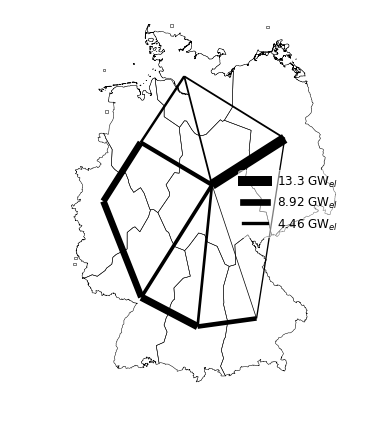

In [47]:
transFilePath = os.path.join(cwd, 'InputData', 'SpatialData','ShapeFiles', 'AClines.shp')

fig, ax = fn.plotLocations(locFilePath, indexColumn='index')                                 
fig, ax = fn.plotTransmission(esM, 'AC cables', transFilePath, loc0='bus0', loc1='bus1', fig=fig, ax=ax)

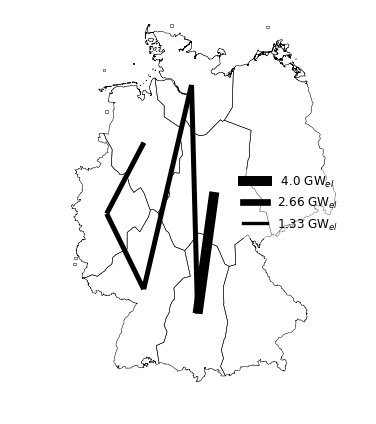

In [48]:
transFilePath = os.path.join(cwd, 'InputData', 'SpatialData','ShapeFiles', 'DClines.shp')

fig, ax = fn.plotLocations(locFilePath, indexColumn='index')                                 
fig, ax = fn.plotTransmission(esM, 'DC cables', transFilePath, loc0='cluster0', loc1='cluster1', fig=fig, ax=ax)

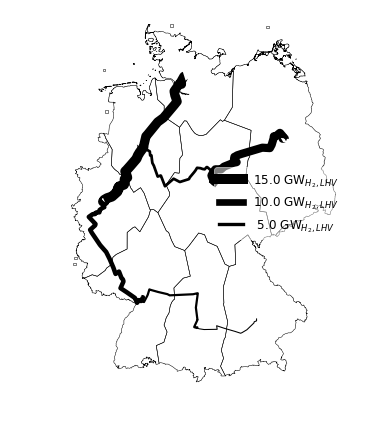

In [49]:
transFilePath = os.path.join(cwd, 'InputData', 'SpatialData','ShapeFiles', 'transmissionPipeline.shp')

fig, ax = fn.plotLocations(locFilePath, indexColumn='index')                                 
fig, ax = fn.plotTransmission(esM, 'Pipelines (hydrogen)', transFilePath, loc0='cluster0', loc1='cluster1',
                              fig=fig, ax=ax)

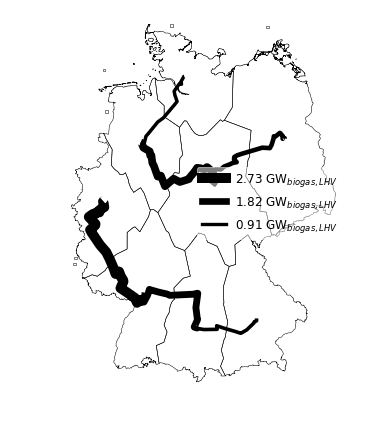

In [50]:
transFilePath = os.path.join(cwd, 'InputData', 'SpatialData','ShapeFiles', 'transmissionPipeline.shp')

fig, ax = fn.plotLocations(locFilePath, indexColumn='index')                                 
fig, ax = fn.plotTransmission(esM, 'Pipelines (biogas)', transFilePath, loc0='cluster0', loc1='cluster1',
                              fig=fig, ax=ax)